<a href="https://colab.research.google.com/github/aashutosharyal/codes/blob/master/ClimateData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring Emissions Data from the Climate Data Portal, https://data.cdp.net/


Note about data: ‘This data was collected in partnership by CDP and ICLEI - Local Governments for Sustainability’.

Notebook by: Melissa Phillips

Inspiration: https://www.charlottesville.gov/295/Charlottesville-Emissions-Reports

Many cities are tracking Greenhouse gas (GHG) emissions and Charlottesville is one of them.  There tends to be a 
2 year delay before dataset can be fully compiled.  Charlotteville's inventories were somewhat sporadic between 2000 an 2015, but annual collections began in 2016.  Earlier inventories (2000, 2006, 2009, 2011) were calculated according to US Reporting Protocols and starting in 2016, data was calculated according to GPC (Global Protocol for Community-Scale GHG Emissions Inventories).  A comprehensive GPC document is in the Drive.  According to the Charlottesville website, when there have been improvements in collection methods, they have been incorporated and applied retrospectively where appropriate.

For the CDP emissions data specifically, cities are able to use direct
measurements of GHG emissions where possible, like by using continuous emissions monitoring systems at power
stations. This is not the norm, though. Most of the GHG measurements will be estimates found by multiplying activity
data by an emission factor associated with the activity being
measured. (pg 50 - 51 of GPG resource)

Note: GHG emissions tend to be measured in metric tonnes.  What does this really mean?  This link is a good resource for context: https://climate.mit.edu/ask-mit/how-much-ton-carbon-dioxide


In [ ]:
# Setting up the notebook

#import pandas and set options
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
# install modules for geopandas and import geopandas
!pip install pandas fiona shapely pyproj rtree
!pip install geopandas
import geopandas as gpd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.7 MB 32.9 MB/s 
     |████████████████████████████████| 6.3 MB 67.8 MB/s 
     |████████████████████████████████| 1.0 MB 59.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 27.3 MB/s 


In [ ]:
# import modules for visualization and set figsize
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

sns.set(rc={'figure.figsize':(15.7,9.27)})


In [ ]:
# import 2021 (latest) emissions data
df = pd.read_csv("/content/drive/MyDrive/Fall2022Hackathon/2021_City-wide_Emissions.csv")
df.head(10)

,Year Reported to CDP,Account Number,Organization,City,Country,CDP Region,Access,City-wide emissions inventory,Accounting year,Administrative city boundary,Inventory boundary (compared to Administrative city boundary),Primary Protocol,Primary Protocol Comment,Gases Included,Direct emissions (metric tonnes CO2e) for Total generation of grid-supplied energy,Direct emissions (metric tonnes CO2e) for Total emissions (excluding generation of grid-supplied energy),Indirect emissions from use of grid supplied energy (metric tonnes CO2e) for Total generation of grid supplied energy,Indirect emissions from use of grid supplied energy (metric tonnes CO2e) for Total Emissions (excluding generation of grid-supplied energy),Emissions occurring outside city boundary (metric tonnes CO2e) for Total Generation of grid supplied energy,Emissions occurring outside city boundary (metric tonnes CO2e) for Total Emissions (excluding generation of grid-supplied energy),TOTAL Scope 1 Emissions (metric tonnes CO2e),TOTAL Scope 2 emissions (metric tonnes CO2e),TOTAL Scope 3 Emissions,TOTAL BASIC Emissions (GPC),TOTAL BASIC+ Emissions (GPC),Change in emissions,Primary reason for the change in emissions,Land area (in square km),Population,Population Year,City Location,Last update
0,2021,834096,"City of Richmond, BC",NaN,Canada,North America,public,Yes,2017-01-01 - 2017-12-31,Local government area within a greater city / ...,Same – covers entire city and nothing else,Global Protocol for Community Greenhouse Gas E...,NaN,CO2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,129.66,224380.0,2020,NaN,10/04/2021 09:23:47 AM
1,2021,859138,Shima City,NaN,Japan,East Asia,public,Yes,2013-04-01 - 2014-03-31,City / Municipality,Same – covers entire city and nothing else,Regional or country specific methodology,NaN,"CH4, CO2, HFCs, N20, NF3, PFCs, SF6",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Do not know,NaN,NaN,NaN,0,NaN,10/04/2021 09:23:47 AM
2,2021,863330,Rourkela,NaN,India,South and West Asia,public,In progress,-,City / Municipality,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,209.00,483629.0,2011,NaN,10/04/2021 09:23:47 AM
3,2021,54354,City Government of Makati,Makati,Philippines,Southeast Asia and Oceania,public,Yes,2018-01-01 - 2018-12-31,City / Municipality,Same – covers entire city and nothing else,2006 IPCC Guidelines for National Greenhouse G...,NaN,CO2,514091.61,782045.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Increased,Increased energy/electricity consumption,27.36,582602.0,2015,POINT (121.024 14.5547),10/04/2021 09:23:47 AM
4,2021,859081,City of Sakuragawa,NaN,Japan,East Asia,public,NaN,NaN,City / Municipality,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,10/04/2021 09:23:47 AM
5,2021,50364,Municipalidad de La Paz,La Paz (Bolivia),Bolivia (Plurinational State of),Latin America,public,Not intending to undertake,NaN,City / Municipality,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,472.00,798.0,2017,POINT (-68.15 -16.5),10/04/2021 09:23:47 AM
6,2021,859068,Hanamaki City,NaN,Japan,East Asia,public,NaN,NaN,City / Municipality,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,10/04/2021 09:23:47 AM
7,2021,852524,Westminster City Council,NaN,United Kingdom of Great Britain and Northern I...,Europe,public,Yes,2018-01-01 - 2018-12-31,Local government area within a greater city / ...,Same – covers entire city and nothing else,Global Protocol for Community Greenhouse Gas E...,We have calculated Westminster's city-wide GHG...,"CH4, CO2, N20",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,This is our first year of calculation,NaN,21.50,255324.0,2018,NaN,10/04/2021 09:23:47 AM
8,2021,8242,City of Helsinki,Helsinki,Finland,Europe,public,Yes,2019-01-01 - 2019-12-31,City / Municipality,Same – covers entire city and nothing else,Global Protocol for Community Greenhouse Gas E...,NaN,"CH4, CO2, N20",3233000.00,824063.00,NaN,1785915.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,In

## Some things to note:

1. The city name is frequently in the "Organization" column
2. There are lots of NaN values! 
3. Gases included can be different


In [ ]:
# gain general understanding of data
df.describe().applymap(lambda x: f"{x:0.2f}")

,Year Reported to CDP,Account Number,Direct emissions (metric tonnes CO2e) for Total generation of grid-supplied energy,Direct emissions (metric tonnes CO2e) for Total emissions (excluding generation of grid-supplied energy),Indirect emissions from use of grid supplied energy (metric tonnes CO2e) for Total generation of grid supplied energy,Indirect emissions from use of grid supplied energy (metric tonnes CO2e) for Total Emissions (excluding generation of grid-supplied energy),Emissions occurring outside city boundary (metric tonnes CO2e) for Total Generation of grid supplied energy,Emissions occurring outside city boundary (metric tonnes CO2e) for Total Emissions (excluding generation of grid-supplied energy),TOTAL Scope 1 Emissions (metric tonnes CO2e),TOTAL Scope 2 emissions (metric tonnes CO2e),TOTAL Scope 3 Emissions,TOTAL BASIC Emissions (GPC),TOTAL BASIC+ Emissions (GPC),Land area (in square km),Population,Population Year
count,989.00,989.00,169.00,332.00,70.00,266.00,58.00,212.00,42.00,38.00,36.00,0.00,0.00,833.00,839.00,989.00
mean,2021.00,345370.18,1123893.64,5427696.41,357862.49,2019019.33,2549.85,918850.19,4540795.39,1297241.37,794800.03,nan,nan,1098046.25,1434540.31,1702.88
std,0.00,385858.32,4168739.49,25648916.70,1684379.55,4696369.99,13711.09,2861521.47,10196783.74,2585373.92,2409527.29,nan,nan,23396440.84,14012309.67,732.71
min,2021.00,1093.00,0.00,0.00,0.00,0.00,0.00,0.00,867.00,0.00,0.00,nan,nan,1.00,1.00,0.00
25%,2021.00,50545.00,0.00,314223.34,0.00,60474.19,0.00,12465.77,206906.50,37650.00,1479.25,nan,nan,80.30,69275.50,2015.00
50%,2021.00,60236.00,9458.80,942021.50,0.00,323216.30,0.00,83184.00,700501.33,238509.00,43188.50,nan,nan,292.00,227827.00,2019.00
75%,2021.00,840936.00,323501.24,3388379.25,291.62,1473144.75,95.68,468775.25,4118308.74,1260571.00,139863.75,nan,nan,1190.12,673001.00,2020.00
max,2021.00,863436.00,36121980.00,411014657.00,12417317.00,36512403.02,95152.00,27315349.00,52177760.00,12415540.00,9586389.00,nan,nan,664000000.00,399724000.00,2021.00


In [ ]:
# view column names
df.columns

Index(['Year Reported to CDP', 'Account Number', 'Organization', 'City',
       'Country', 'CDP Region', 'Access', 'City-wide emissions inventory',
       'Accounting year', 'Administrative city boundary',
       'Inventory boundary (compared to Administrative city boundary)',
       'Primary Protocol', 'Primary Protocol Comment', 'Gases Included',
       'Direct emissions (metric tonnes CO2e) for Total generation of grid-supplied energy',
       'Direct emissions (metric tonnes CO2e) for Total emissions (excluding generation of grid-supplied energy)',
       'Indirect emissions from use of grid supplied energy (metric tonnes CO2e) for Total generation of grid supplied energy',
       'Indirect emissions from use of grid supplied energy (metric tonnes CO2e) for Total Emissions (excluding generation of grid-supplied energy)',
       'Emissions occurring outside city boundary (metric tonnes CO2e) for Total Generation of grid supplied energy',
       'Emissions occurring outside city boun

In [ ]:
# make column heading lower case and put underscores where spaces were
df.columns = df.columns.str.lower().str.replace(' ','_').str.replace('(','').str.replace(')','')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


In [ ]:
df.columns

Index(['year_reported_to_cdp', 'account_number', 'organization', 'city',
       'country', 'cdp_region', 'access', 'city-wide_emissions_inventory',
       'accounting_year', 'administrative_city_boundary',
       'inventory_boundary_compared_to_administrative_city_boundary',
       'primary_protocol', 'primary_protocol_comment', 'gases_included',
       'direct_emissions_metric_tonnes_co2e_for_total_generation_of_grid-supplied_energy',
       'direct_emissions_metric_tonnes_co2e_for_total_emissions_excluding_generation_of_grid-supplied_energy',
       'indirect_emissions_from_use_of_grid_supplied_energy_metric_tonnes_co2e_for_total_generation_of_grid_supplied_energy',
       'indirect_emissions_from_use_of_grid_supplied_energy_metric_tonnes_co2e_for_total_emissions_excluding_generation_of_grid-supplied_energy',
       'emissions_occurring_outside_city_boundary_metric_tonnes_co2e_for_total_generation_of_grid_supplied_energy',
       'emissions_occurring_outside_city_boundary_metric_tonn

In [ ]:
# checking out Charlottesville stats before we clean the dataset
df[df["organization"]=='City of Charlottesville']

,year_reported_to_cdp,account_number,organization,city,country,cdp_region,access,city-wide_emissions_inventory,accounting_year,administrative_city_boundary,inventory_boundary_compared_to_administrative_city_boundary,primary_protocol,primary_protocol_comment,gases_included,direct_emissions_metric_tonnes_co2e_for_total_generation_of_grid-supplied_energy,direct_emissions_metric_tonnes_co2e_for_total_emissions_excluding_generation_of_grid-supplied_energy,indirect_emissions_from_use_of_grid_supplied_energy_metric_tonnes_co2e_for_total_generation_of_grid_supplied_energy,indirect_emissions_from_use_of_grid_supplied_energy_metric_tonnes_co2e_for_total_emissions_excluding_generation_of_grid-supplied_energy,emissions_occurring_outside_city_boundary_metric_tonnes_co2e_for_total_generation_of_grid_supplied_energy,emissions_occurring_outside_city_boundary_metric_tonnes_co2e_for_total_emissions_excluding_generation_of_grid-supplied_energy,total_scope_1_emissions_metric_tonnes_co2e,total_scope_2_emissions_metric_tonnes_co2e,total_scope_3_emissions,total_basic_emissions_gpc,total_basic+_emissions_gpc,change_in_emissions,primary_reason_for_the_change_in_emissions,land_area_in_square_km,population,population_year,city_location,last_update


In [ ]:
# choosing the columns I want to focus on 
df_reduced = df[['country', 'organization', 'cdp_region', 'gases_included', 'land_area_in_square_km',
                 'population', 'population_year', 'change_in_emissions', 
                 'city', 'direct_emissions_metric_tonnes_co2e_for_total_generation_of_grid-supplied_energy',
                 'direct_emissions_metric_tonnes_co2e_for_total_emissions_excluding_generation_of_grid-supplied_energy',
                 'primary_reason_for_the_change_in_emissions', 'city_location', 'last_update'
                 ]]

In [ ]:
# rename direct emissions columns
df_reduced.rename(columns = {"direct_emissions_metric_tonnes_co2e_for_total_generation_of_grid-supplied_energy":"direct_emissions_grid",\
                             "direct_emissions_metric_tonnes_co2e_for_total_emissions_excluding_generation_of_grid-supplied_energy":\
                             "direct_emissions_non_grid"}, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
df_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 989 entries, 0 to 988
Data columns (total 14 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   country                                     989 non-null    object 
 1   organization                                989 non-null    object 
 2   cdp_region                                  989 non-null    object 
 3   gases_included                              665 non-null    object 
 4   land_area_in_square_km                      833 non-null    float64
 5   population                                  839 non-null    float64
 6   population_year                             989 non-null    int64  
 7   change_in_emissions                         551 non-null    object 
 8   city                                        548 non-null    object 
 9   direct_emissions_grid                       169 non-null    float64
 10  direct_emissio

In [ ]:
# should make a decision about Nan values.  I'm choosing to remove rows where either direct emissions value is null
df_clean = df_reduced[df_reduced['direct_emissions_grid']\
                      .notna()].reset_index(drop=True)
df_clean = df_clean[df_clean['direct_emissions_non_grid']\
                    .notna()].reset_index(drop=True)


In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 14 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   country                                     167 non-null    object 
 1   organization                                167 non-null    object 
 2   cdp_region                                  167 non-null    object 
 3   gases_included                              167 non-null    object 
 4   land_area_in_square_km                      167 non-null    float64
 5   population                                  167 non-null    float64
 6   population_year                             167 non-null    int64  
 7   change_in_emissions                         164 non-null    object 
 8   city                                        142 non-null    object 
 9   direct_emissions_grid                       167 non-null    float64
 10  direct_emissio

In [ ]:
df_clean.head()

,country,organization,cdp_region,gases_included,land_area_in_square_km,population,population_year,change_in_emissions,city,direct_emissions_grid,direct_emissions_non_grid,primary_reason_for_the_change_in_emissions,city_location,last_update
0,Philippines,City Government of Makati,Southeast Asia and Oceania,CO2,27.36,582602.0,2015,Increased,Makati,514091.61,782045.75,Increased energy/electricity consumption,POINT (121.024 14.5547),10/04/2021 09:23:47 AM
1,Finland,City of Helsinki,Europe,"CH4, CO2, N20",214.25,655395.0,2020,Increased,Helsinki,3233000.00,824063.00,Change in weather conditions,POINT (24.941 60.1733),10/04/2021 09:23:47 AM
2,United Kingdom of Great Britain and Northern I...,Sunderland City Council,Europe,"CH4, CO2, N20",139.50,277417.0,2018,This is our first year of calculation,Sunderland,2.82,1091482.57,"Other, please specify: Calculating an emission...",NaN,10/04/2021 09:23:47 AM
3,United States of America,"City of Phoenix, AZ",North America,"CH4, CO2, N20",1339.00,1660272.0,2018,Decreased,Phoenix,1391552.00,8666375.00,Technological change,POINT (-112.074 33.4484),10/04/2021 09:23:47 AM
4,Argentina,San Carlos Sud,Latin America,"CH4, CO2, N20",95.00,2233.0,2018,Increased,NaN,0.00,35803.01,Change in available data,NaN,10/04/2021 09:23:47 AM


We have read in and reduced a single data set.  If we want to clean a few data sets that look similar, we can make some repeatable methods so it goes more quickly.

# Lots of Questions We Could Answer:

1. Which cities reported emissions in 2021 and how much was reported?
2. Do emissions relate to population size?  If so, in what way?
3. Do emissions relate to where the city is located (which country, continent, etc.)?
4. How have emissions changed over time?  How were they affected by the early stages of the COVID pandemic?

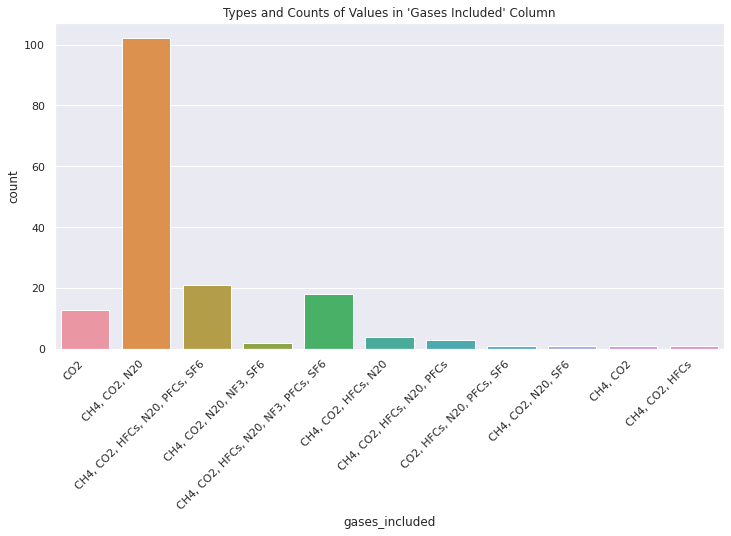

In [ ]:
# what are we seeing in the 'gases_included' column?
fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(data=df_clean, x='gases_included', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title("Types and Counts of Values in 'Gases Included' Column")
plt.show()


In [ ]:
# for comparing countries within this dataset, we can choose to only focus on data with CH4,C02,N20
df_clean = df_clean[df_clean['gases_included']=="CH4, CO2, N20"]

## How Do Direct Emissions Relate to Population?

In [ ]:
# plot direct emissions related and unrelated to energy generation
df_clean = df_clean.sort_values(by=['population'])

[Text(0.5, 1.0, 'Direct Emissions (metric tonnes C02e) for Total Generation of Grid Supplied Energy vs Population')]

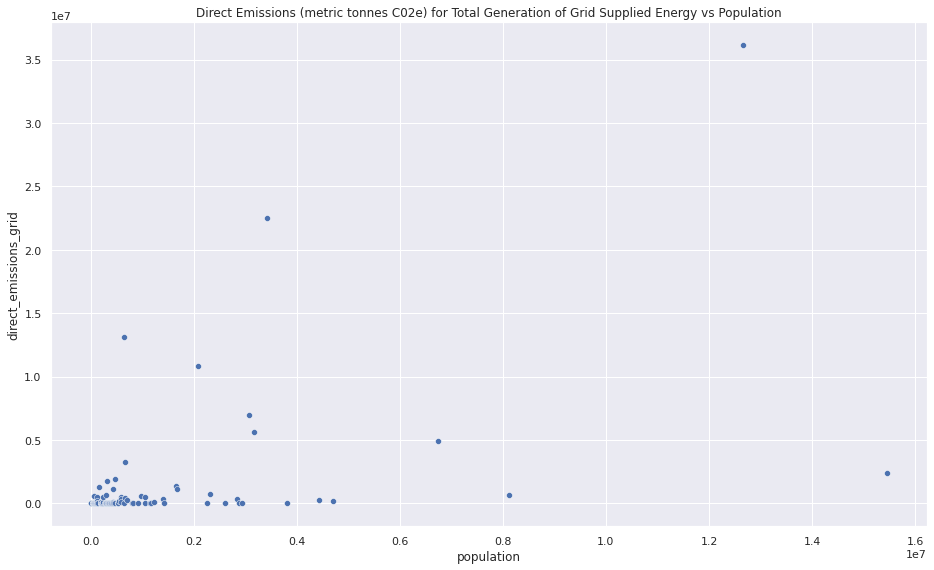

In [ ]:
sns.scatterplot(data=df_clean, x="population", y="direct_emissions_grid").set(title="Direct Emissions (metric tonnes C02e) for Total Generation of Grid Supplied Energy vs Population")

In [ ]:
# plotly plot for emissions vs population 
fig = px.scatter(df_clean, x="population", y="direct_emissions_grid", color="country", 
                 labels={
                     "pop_density": "Population Density (people per square km)",
                     "direct_emissions_grid": "Direct Emissions (metric tonnes C02e)",
                     "country": "Country"
                 },
                 title="Direct Emissions (metric tonnes C02e) for Total Generation of Grid Supplied Energy vs Population"
                 )
fig.show()

In [ ]:
# correlation with population density?
df_clean['pop_density'] = df_clean['population'] / df_clean['land_area_in_square_km'] 

[Text(0.5, 1.0, 'Direct Emissions (metric tonnes C02e) for Total Generation of Grid Supplied Energy vs Population Density')]

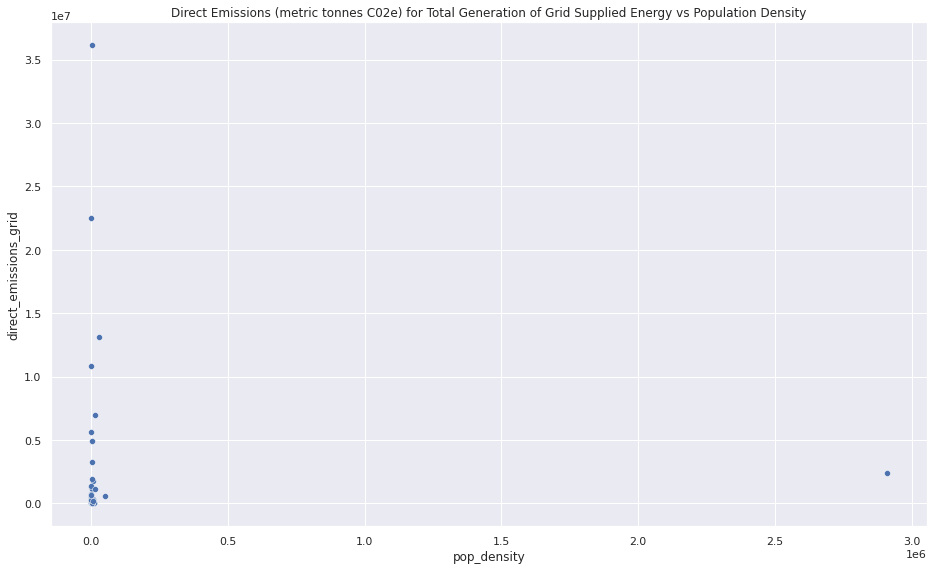

In [ ]:
# seaborn plot
sns.scatterplot(data=df_clean, x="pop_density", y="direct_emissions_grid").set(title="Direct Emissions (metric tonnes C02e) for Total Generation of Grid Supplied Energy vs Population Density")

In [ ]:
# plotly plot for emissions vs population density
fig = px.scatter(df_clean, x="pop_density", y="direct_emissions_grid", color="country", 
                 labels={
                     "pop_density": "Population Density (people per square km)",
                     "direct_emissions_grid": "Direct Emissions (metric tonnes C02e)",
                     "country": "Country"
                 },
                 title="Direct Emissions (metric tonnes C02e) for Total Generation of Grid Supplied Energy vs Population Density"
                 )
fig.show()

# Show average direct emissions related to Grid supply energy by country

In [ ]:
# group the df by country and find the mean
df_country = df_clean.groupby(by=['country'], dropna=False).mean().reset_index()

In [ ]:
# https://www.naturalearthdata.com/downloads/110m-physical-vectors/
gdf_countries = gpd.read_file("/content/drive/MyDrive/Fall2022Hackathon/countries_shapefiles/ne_110m_admin_0_countries.shp")

In [ ]:
# country polygon gdf
gdf_countries.head(5)

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,ADM0_A3,GEOU_DIF,GEOUNIT,GU_A3,SU_DIF,SUBUNIT,SU_A3,BRK_DIFF,NAME,NAME_LONG,BRK_A3,BRK_NAME,BRK_GROUP,ABBREV,POSTAL,FORMAL_EN,FORMAL_FR,NAME_CIAWF,NOTE_ADM0,NOTE_BRK,NAME_SORT,NAME_ALT,MAPCOLOR7,MAPCOLOR8,MAPCOLOR9,MAPCOLOR13,POP_EST,POP_RANK,POP_YEAR,GDP_MD,GDP_YEAR,ECONOMY,INCOME_GRP,FIPS_10,ISO_A2,ISO_A2_EH,ISO_A3,ISO_A3_EH,ISO_N3,ISO_N3_EH,UN_A3,WB_A2,WB_A3,WOE_ID,WOE_ID_EH,WOE_NOTE,ADM0_ISO,ADM0_DIFF,ADM0_TLC,ADM0_A3_US,ADM0_A3_FR,ADM0_A3_RU,ADM0_A3_ES,ADM0_A3_CN,ADM0_A3_TW,ADM0_A3_IN,ADM0_A3_NP,ADM0_A3_PK,ADM0_A3_DE,ADM0_A3_GB,ADM0_A3_BR,ADM0_A3_IL,ADM0_A3_PS,ADM0_A3_SA,ADM0_A3_EG,ADM0_A3_MA,ADM0_A3_PT,ADM0_A3_AR,ADM0_A3_JP,ADM0_A3_KO,ADM0_A3_VN,ADM0_A3_TR,ADM0_A3_ID,ADM0_A3_PL,ADM0_A3_GR,ADM0_A3_IT,ADM0_A3_NL,ADM0_A3_SE,ADM0_A3_BD,ADM0_A3_UA,ADM0_A3_UN,ADM0_A3_WB,CONTINENT,REGION_UN,SUBREGION,REGION_WB,NAME_LEN,LONG_LEN,ABBREV_LEN,TINY,HOMEPART,MIN_ZOOM,MIN_LABEL,MAX_LABEL,LABEL_X,LABEL_Y,NE_ID,WIKIDATAID,NAME_AR,NAME_BN,NAME_DE,NAME_EN,NAME_ES,NAME_FA,NAME_FR,NAME_EL,NAME_HE,NAME_HI,NAME_HU,NAME_ID,NAME_IT,NAME_JA,NAME_KO,NAME_NL,NAME_PL,NAME_PT,NAME_RU,NAME_SV,NAME_TR,NAME_UK,NAME_UR,NAME_VI,NAME_ZH,NAME_ZHT,FCLASS_ISO,TLC_DIFF,FCLASS_TLC,FCLASS_US,FCLASS_FR,FCLASS_RU,FCLASS_ES,FCLASS_CN,FCLASS_TW,FCLASS_IN,FCLASS_NP,FCLASS_PK,FCLASS_DE,FCLASS_GB,FCLASS_BR,FCLASS_IL,FCLASS_PS,FCLASS_SA,FCLASS_EG,FCLASS_MA,FCLASS_PT,FCLASS_AR,FCLASS_JP,FCLASS_KO,FCLASS_VN,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry
0,Admin-0 country,1,6,Fiji,FJI,0,2,Sovereign country,1,Fiji,FJI,0,Fiji,FJI,0,Fiji,FJI,0,Fiji,Fiji,FJI,Fiji,None,Fiji,FJ,Republic of Fiji,None,Fiji,None,None,Fiji,None,5,1,2,2,889953.0,11,2019,5496,2019,6. Developing region,4. Lower middle income,FJ,FJ,FJ,FJI,FJI,242,242,242,FJ,FJI,23424813,23424813,Exact WOE match as country,FJI,None,FJI,FJI,FJI,FJI,FJI,FJI,FJI,FJI,FJI,FJI,FJI,FJI,FJI,FJI,FJI,FJI,FJI,FJI,FJI,FJI,FJI,FJI,FJI,FJI,FJI,FJI,FJI,FJI,FJI,FJI,FJI,FJI,-99,-99,Oceania,Oceania,Melanesia,East Asia & Pacific,4,4,4,-99,1,0.0,3.0,8.0,177.975427,-17.826099,1159320625,Q712,فيجي,ফিজি,Fidschi,Fiji,Fiyi,فیجی,Fidji,Φίτζι,פיג'י,फ़िजी,Fidzsi-szigetek,Fiji,Figi,フィジー,피지,Fiji,Fidżi,Fiji,Фиджи,Fiji,Fiji,Фіджі,فجی,Fiji,斐济,斐濟,Admin-0 country,None,Admin-0 country,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,Admin-0 country,1,3,United Republic of Tanzania,TZA,0,2,Sovereign country,1,United Republic of Tanzania,TZA,0,Tanzania,TZA,0,Tanzania,TZA,0,Tanzania,Tanzania,TZA,Tanzania,None,Tanz.,TZ,United Republic of Tanzania,None,Tanzania,None,None,Tanzania,None,3,6,2,2,58005463.0,16,2019,63177,2019,7. Least developed region,5. Low income,TZ,TZ,TZ,TZA,TZA,834,834,834,TZ,TZA,23424973,23424973,Exact WOE match as country,TZA,None,TZA,TZA,TZA,TZA,TZA,TZA,TZA,TZA,TZA,TZA,TZA,TZA,TZA,TZA,TZA,TZA,TZA,TZA,TZA,TZA,TZA,TZA,TZA,TZA,TZA,TZA,TZA,TZA,TZA,TZA,TZA,TZA,-99,-99,Africa,Africa,Eastern Africa,Sub-Saharan Africa,8,8,5,-99,1,0.0,3.0,8.0,34.959183,-6.051866,1159321337,Q924,تنزانيا,তানজানিয়া,Tansania,Tanzania,Tanzania,تانزانیا,Tanzanie,Τανζανία,טנזניה,तंज़ानिया,Tanzánia,Tanzania,Tanzania,タンザニア,탄자니아,Tanzania,Tanzania,Tanzânia,Танзания,Tanzania,Tanzanya,Танзанія,تنزانیہ,Tanzania,坦桑尼亚,坦尚尼亞,Admin-0 country,None,Admin-0 country,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,Admin-0 country,1,7,Western Sahara,SAH,0,2,Indeterminate,1,Western Sahara,SAH,0,Western Sahara,SAH,0,Western Sahara,SAH,1,W. Sahara,Western Sahara,B28,W. Sahara,None,W. Sah.,WS,Sahrawi Arab Democratic Republic,None,Western Sahara,None,Self admin.; Claimed by Morocco,Western Sahara,None,4,7,4,4,603253.0,11,2017,907,2007,7. Least develope

In [ ]:
df_country.rename(columns={"country":"ADMIN"}, inplace=True)

In [ ]:
df_country.head(1)

,ADMIN,land_area_in_square_km,population,population_year,direct_emissions_grid,direct_emissions_non_grid,pop_density
0,Argentina,3006.0,561886.333333,2015.333333,1167504.645,1.554726e+06,2599.652199


In [ ]:
df_country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ADMIN                      30 non-null     object 
 1   land_area_in_square_km     30 non-null     float64
 2   population                 30 non-null     float64
 3   population_year            30 non-null     float64
 4   direct_emissions_grid      30 non-null     float64
 5   direct_emissions_non_grid  30 non-null     float64
 6   pop_density                30 non-null     float64
dtypes: float64(6), object(1)
memory usage: 1.8+ KB


In [ ]:
# replace entry for Russia, Taiwan and United Kingdom in df_country
df_country.replace({"Russian Federation":"Russia", "Taiwan, Greater China":"Taiwan", "United Kingdom of Great Britain and Northern Ireland":"United Kingdom"}, inplace=True)

In [ ]:
df_country_merged = pd.merge(df_country, gdf_countries, on='ADMIN')

In [ ]:
df_country_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 0 to 29
Columns: 175 entries, ADMIN to geometry
dtypes: float64(12), geometry(1), int64(25), object(137)
memory usage: 41.2+ KB


In [ ]:
# reduce df for direct emissions relating to grid
df_country_reduced = df_country_merged[["ADMIN", "geometry", "direct_emissions_grid"]]

In [ ]:
# turn df_country_reduced into a geodataframe
gdf = gpd.GeoDataFrame(df_country_reduced, geometry="geometry", crs="EPSG:4326")

(-198.0, 198.00000000000006, -62.554083500000004, 90.17549350000003)

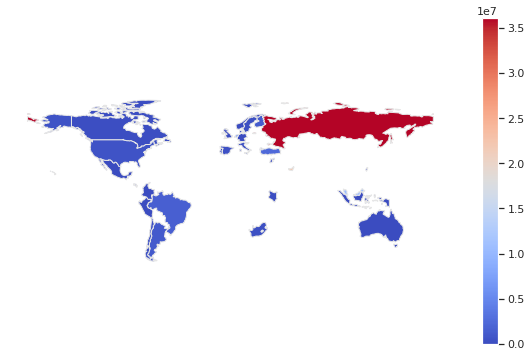

In [ ]:
# matplotlib choropleth plot
fig, ax = plt.subplots(1, figsize=(10,6))
gdf.plot('direct_emissions_grid', cmap='coolwarm', linewidth=1, ax=ax, edgecolor='0.9', legend = True)
ax.axis('off')

In [ ]:
# plotly choropleth
# used https://medium.com/@anguyen61191/choropleth-maps-in-python-ce6a63f3b749 as tutorial
fig = px.choropleth(gdf, geojson=gdf.geometry, 
                    locations=gdf.index, color="direct_emissions_grid",
                    height=500,
                   color_continuous_scale="Viridis")
fig.update_geos(fitbounds="locations", visible=True)
fig.update_layout(
    title_text='Average Direct Emissions Connected to Grid by Country Reporting')
fig.update(layout = dict(title=dict(x=0.5)))
fig.update_layout(
    margin={"r":0,"t":30,"l":10,"b":10},
    coloraxis_colorbar={
        'title':'Direct Emissions in Metric Tonnes'})
fig.show()

In [ ]:
df_usa = df_reduced[df_reduced['country']=='United States of America']

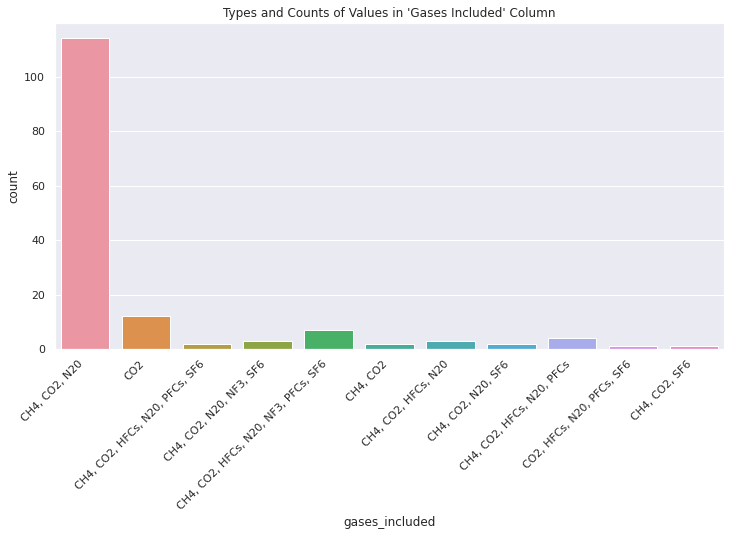

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(data=df_usa, x='gases_included', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title("Types and Counts of Values in 'Gases Included' Column")
plt.show()

In [ ]:
# only look at CH4,CO2,N20
df_usa = df_usa[df_usa["gases_included"]=="CH4, CO2, N20"]

# Show average direct emissions related to Grid supply Energy by State

In [ ]:
gdf_states = gpd.read_file("/content/drive/MyDrive/Fall2022Hackathon/state_shapefiles/ne_110m_admin_1_states_provinces.shp")


In [ ]:
gdf_states.head()

,featurecla,scalerank,adm1_code,diss_me,iso_3166_2,wikipedia,iso_a2,adm0_sr,name,name_alt,name_local,type,type_en,code_local,code_hasc,note,hasc_maybe,region,region_cod,provnum_ne,gadm_level,check_me,datarank,abbrev,postal,area_sqkm,sameascity,labelrank,name_len,mapcolor9,mapcolor13,fips,fips_alt,woe_id,woe_label,woe_name,latitude,longitude,sov_a3,adm0_a3,adm0_label,admin,geonunit,gu_a3,gn_id,gn_name,gns_id,gns_name,gn_level,gn_region,gn_a1_code,region_sub,sub_code,gns_level,gns_lang,gns_adm1,gns_region,min_label,max_label,min_zoom,wikidataid,name_ar,name_bn,name_de,name_en,name_es,name_fr,name_el,name_hi,name_hu,name_id,name_it,name_ja,name_ko,name_nl,name_pl,name_pt,name_ru,name_sv,name_tr,name_vi,name_zh,ne_id,name_he,name_uk,name_ur,name_fa,name_zht,FCLASS_ISO,FCLASS_US,FCLASS_FR,FCLASS_RU,FCLASS_ES,FCLASS_CN,FCLASS_TW,FCLASS_IN,FCLASS_NP,FCLASS_PK,FCLASS_DE,FCLASS_GB,FCLASS_BR,FCLASS_IL,FCLASS_PS,FCLASS_SA,FCLASS_EG,FCLASS_MA,FCLASS_PT,FCLASS_AR,FCLASS_JP,FCLASS_KO,FCLASS_VN,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,FCLASS_TLC,geometry
0,Admin-1 scale rank,2,USA-3514,3514,US-MN,http://en.wikipedia.org/wiki/Minnesota,US,1,Minnesota,MN|Minn.,None,State,State,US27,US.MN,None,None,Midwest,None,0,1,20,1,Minn.,MN,0,-99,0,9,1,1,US27,None,2347582,"Minnesota, US, United States",Minnesota,46.0592,-93.364,US1,USA,2,United States of America,United States of America,USA,5037779,Minnesota,-1,None,1,None,US.MN,West North Central,None,-1,None,None,None,3.5,7.5,2,Q1527,مينيسوتا,মিনেসোটা,Minnesota,Minnesota,Minnesota,Minnesota,Μινεσότα,मिनेसोटा,Minnesota,Minnesota,Minnesota,ミネソタ州,미네소타,Minnesota,Minnesota,Minnesota,Миннесота,Minnesota,Minnesota,Minnesota,明尼苏达州,1159315297,מינסוטה,Міннесота,مینیسوٹا,مینهسوتا,明尼蘇達州,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,"POLYGON ((-89.95766 47.28691, -90.13175 47.292..."
1,Admin-1 scale rank,2,USA-3515,3515,US-MT,http://en.wikipedia.org/wiki/Montana,US,1,Montana,MT|Mont.,None,State,State,US30,US.MT,None,None,West,None,0,1,20,1,Mont.,MT,0,-99,0,7,1,1,US30,None,2347585,"Montana, US, United States",Montana,46.9965,-110.044,US1,USA,2,United States of America,United States of America,USA,5667009,Montana,-1,None,1,None,US.MT,Mountain,None,-1,None,None,None,3.5,7.5,2,Q1212,مونتانا,মন্টানা,Montana,Montana,Montana,Montana,Μοντάνα,मोन्टाना,Montana,Montana,Montana,モンタナ州,몬태나,Montana,Montana,Montana,Монтана,Montana,Montana,Montana,蒙大拿州,1159315333,מונטנה,Монтана,مونٹانا,ایالت مونتانا,蒙大拿州,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,"POLYGON ((-116.04823 49.00037, -113.05950 49.0..."
2,Admin-1 scale rank,2,USA-3516,3516,US-ND,http://en.wikipedia.org/wiki/North_Dakota,US,1,North Dakota,ND|N.D.,None,State,State,US38,US.ND,None,None,Midwest,None,0,1,20,1,N.D.,ND,0,-99,0,12,1,1,US38,None,2347593,"North Dakota, US, United States",North Dakota,47.4675,-100.302,US1,USA,2,United States of America,United States of America,USA,5690763,North Dakota,-1,None,1,None,US.ND,West North Central,None,-1,None,None,None,3.5,7.5,2,Q1207,داكوتا الشمالية,নর্থ ডাকোটা,North Dakota,North Dakota,Dakota del Norte,Dakota du Nord,Βόρεια Ντακότα,उत्तर डेकोटा,Észak-Dakota,Dakota Utara,Dakota del Nord,ノースダコタ州,노스다코타,Noord-Dakota,Dakota Północna,Dakota do Norte,Северная Дакота,North Dakota,Kuzey Dakota,Bắc Dakota,北达科他州,1159315337,דקוטה הצפונית,Північна Дакота,شمالی ڈکوٹا,داکوتای شمالی,北達科他州,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,"POLYGON ((-97.22894 49.00089, -97.21414 48.902..."
3,Admin-1 scale rank,2,USA-3517,3517,US-HI,http://en.wikipedia.org/wiki/Hawaii,US,8,Hawaii,HI|Hawaii,None,State,State,US15,US.HI,None,None,West,None,0,1,20,1,Hawaii,HI,0,

In [ ]:
df_usa["state"] = df_usa["organization"].str.replace(r'^[^,]*,\s*', '')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

The default value of regex will change from True to False in a future version.



In [ ]:
df_usa_grouped = df_usa.groupby(by=["state"], dropna=False).mean().reset_index()
df_usa_grouped["postal"] = df_usa_grouped["state"]

In [ ]:
df_usa_merged = pd.merge(df_usa_grouped, gdf_states, on='postal')

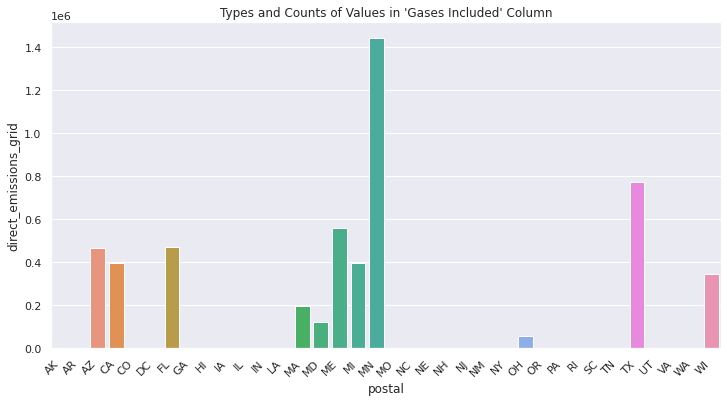

In [ ]:
# how do American cities compare to each other?
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=df_usa_merged, x='postal', y="direct_emissions_grid", ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title("Types and Counts of Values in 'Gases Included' Column")
plt.show()


In [ ]:
# turn df_country_reduced into a geodataframe
gdf_usa = gpd.GeoDataFrame(df_usa_merged, geometry="geometry", crs="EPSG:4326")

In [ ]:
# plotly choropleth
# used https://medium.com/@anguyen61191/choropleth-maps-in-python-ce6a63f3b749 as tutorial
fig = px.choropleth(gdf_usa, geojson=gdf_usa.geometry, 
                    locations=gdf_usa.index, color="direct_emissions_grid",
                    height=500,
                   color_continuous_scale="Viridis")
fig.update_geos(fitbounds="locations", visible=True)
fig.update_layout(
    title_text='Average Direct Emissions Connected to Grid by State Reporting')
fig.update(layout = dict(title=dict(x=0.5)))
fig.update_layout(
    margin={"r":0,"t":30,"l":10,"b":10},
    coloraxis_colorbar={
        'title':'Direct Emissions in Metric Tonnes'})
fig.show()